# 手写数字

## 导包
- 可视化图像： matplotlib
- 搭建神经网络：torch
    - 建数据集：data
- 可视化神经网络：tensorboard
- 处理、变换图像：torchvision


In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch import nn

import torchvision

import pytorch_lightning as pl


## 设超参数
- 锻炼世代
- 一批数据大小
- 学习率

In [2]:
args = type('args', (object,), {})()
args.batch_size = 16
# args.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# print(args.device)


## 加载数据集

60000
torch.Size([1, 28, 28]) 5
torch.Size([16, 1, 28, 28]) torch.Size([16])


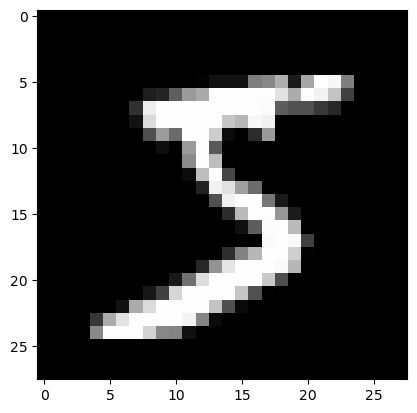

In [3]:
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, ToTensor, Normalize
from torch.utils.data import random_split
from pytorch_lightning import LightningDataModule

transform = Compose([
    ToTensor(),
    Normalize((0.1307,), (0.3801,))  # 正则化，降低模型复杂度
])

tr_set = MNIST('data', train=True, download=True, transform=transform)

print(len(tr_set))

img, label = tr_set[0]
print(img.shape, label)

plt.imshow(img.squeeze(), cmap='gray')

# 遍历一次取一批数据
tr_loader = DataLoader(tr_set, batch_size=args.batch_size, shuffle=True)

imgs, labels = next(iter(tr_loader))
print(imgs.shape, labels.shape)


class MNISTDataModule(LightningDataModule):
    def __init__(self, data_dir: str = "./data", batch_size: int = 32, num_workers: int = 6):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers

        self.transform = Compose([
            ToTensor(),
            Normalize((0.1307,), (0.3081,))
        ])

    def prepare_data(self):
        # download
        MNIST(self.data_dir, train=True, download=True)
        MNIST(self.data_dir, train=False, download=True)

    def setup(self, stage: str):
        # Assign train/val datasets for use in dataloaders
        if stage == "fit":
            mnist_full = MNIST(self.data_dir, train=True, transform=self.transform)
            self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])

        # Assign test dataset for use in dataloader(s)
        if stage == "test":
            self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transform)

        if stage == "predict":
            self.mnist_predict = MNIST(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.mnist_train, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=self.batch_size, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.mnist_test, batch_size=self.batch_size, num_workers=self.num_workers)

    def predict_dataloader(self):
        return DataLoader(self.mnist_predict, batch_size=self.batch_size, num_workers=self.num_workers)


mnist_dm = MNISTDataModule()

## 模型

In [31]:
from torchvision.ops import Permute
from functools import partial


class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, 5),  # B * 1 * 28 * 28 -> B * 16 * 24 * 24
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # -> B * 16 * 12 * 12
            nn.Conv2d(16, 24, 3),  # -> B * 24 * 10 * 10
            nn.ReLU()
        )

        self.fc = nn.Sequential(
            nn.Linear(24 * 10 * 10, 480),  # B * 2400 -> B * 480
            nn.ReLU(),
            nn.Linear(480, 10)
        )

    def forward(self, x):
        input_size = x.size(0)
        x = self.conv(x)
        x = x.view(input_size, -1)

        return self.fc(x)


from torchvision.models.swin_transformer import SwinTransformerBlockV2, PatchMergingV2, swin_v2_t, Swin_V2_T_Weights


class TransNet(nn.Module):
    def __init__(self):
        super(TransNet, self).__init__()

        self.trans = swin_v2_t(weights=Swin_V2_T_Weights.DEFAULT)
        self.fc = nn.Linear(1000, 10)

        # self.embed_dim = 96
        #
        # norm_layer = partial(nn.LayerNorm, eps=1e-5)
        #
        # self.patch_embed = nn.Sequential(
        #     nn.Conv2d(3, self.embed_dim, kernel_size=(4, 4), stride=(4, 4)),  # 3 * 28 * 28 -> 96 * 7 * 7
        #     Permute([0, 2, 3, 1]),  # B C H W -> B H W C
        #     norm_layer(self.embed_dim)  # 归一化
        # )
        #
        # self.basic_block = nn.Sequential(  # 7 * 7 * 96 -> 7 * 7 * 96
        #     SwinTransformerBlockV2(
        #         dim=self.embed_dim,
        #         num_heads=3,
        #         shift_size=[0, 0],
        #         window_size=[8, 8],
        #     ),
        #     SwinTransformerBlockV2(
        #         dim=self.embed_dim,
        #         num_heads=3,
        #         shift_size=[4, 4],
        #         window_size=[8, 8],
        #     ),
        # )
        #
        # self.patch_merge = PatchMergingV2(  # 7 * 7 * 96 -> 4 * 4 * 192
        #     dim=self.embed_dim,
        #     norm_layer=norm_layer
        # )
        #
        # self.permute = Permute([0, 3, 1, 2])  # B H W C -> B C H W
        # self.avgpool = nn.AdaptiveAvgPool2d(1)
        # self.flatten = nn.Flatten(1)
        #
        # self.head = nn.Linear(192, 10)

    def forward(self, x):
        # x = self.patch_embed(x)  # B * 7 * 7 * 96
        # x = self.basic_block(x)  # B * 7 * 7 * 96
        # x = self.patch_merge(x)  # B * 4 * 4 * 192
        #
        # x = self.permute(x)
        # x = self.avgpool(x)
        # x = self.flatten(x)
        # x = self.head(x)

        x = self.trans(x)
        x = self.fc(x)
        return x


model = TransNet()
print('model loaded')

model loaded


In [5]:
cat_imgs = torch.cat([imgs, imgs, imgs], dim=1)
# print(cat_imgs.shape)  # B * 3 * 28 * 28

output = model(cat_imgs)
print(output.shape)


torch.Size([16, 10])


In [32]:
from pytorch_lightning import LightningModule
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torchmetrics.classification import MulticlassAccuracy


class TransLitModule(LightningModule):
    def __init__(self, batch_size=32, lr=0.001):
        super(TransLitModule, self).__init__()
        self.save_hyperparameters()

        self.model = TransNet()

        self.loss_fn = CrossEntropyLoss()

        self.acc = MulticlassAccuracy(num_classes=10)

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        return Adam(self.parameters(), lr=self.hparams.lr)

    def training_step(self, batch, batch_idx):
        imgs, labels = batch
        cat_imgs = torch.cat([imgs, imgs, imgs], dim=1)

        preds = self(cat_imgs)
        loss = self.loss_fn(preds, labels)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        imgs, labels = batch
        cat_imgs = torch.cat([imgs, imgs, imgs], dim=1)

        pred = self(cat_imgs)
        loss = self.loss_fn(pred, labels)
        self.log('val_loss', loss)
        return loss

    def test_step(self, batch, batch_idx):
        imgs, labels = batch
        cat_imgs = torch.cat([imgs, imgs, imgs], dim=1)

        pred = self(cat_imgs)
        loss = self.loss_fn(pred, labels)
        self.acc(pred, labels)
        self.log('test_loss', loss)
        self.log('test_acc', self.acc, on_step=False, on_epoch=True)
        return loss


module = TransLitModule(256)
print('module loaded')

module loaded


In [33]:
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

checkpoint_callback = ModelCheckpoint(
    monitor='train_loss',
    save_top_k=3,
    mode='min',
    save_last=True
)

early_stop_callback = EarlyStopping(
    monitor='val_loss',
    patience=3,
    mode='min'
)

logger = TensorBoardLogger('tb_logs', name='transnet')


In [34]:
from pytorch_lightning import Trainer
from pytorch_lightning.tuner import Tuner

trainer = Trainer(
    max_epochs=3, val_check_interval=0.5,
    precision='16-mixed',
    logger=logger,
    callbacks=[checkpoint_callback, early_stop_callback],
    # fast_dev_run=True
)

# tuner = Tuner(trainer)
#
# tuner.lr_find(module, datamodule=mnist_dm)
# tuner.scale_batch_size(module, datamodule=mnist_dm)

print(module.hparams)


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


"batch_size": 256
"lr":         0.001


In [35]:

trainer.fit(module, datamodule=mnist_dm)

trainer.test(module, datamodule=mnist_dm)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type               | Params
-----------------------------------------------
0 | model   | TransNet           | 28.4 M
1 | loss_fn | CrossEntropyLoss   | 0     
2 | acc     | MulticlassAccuracy | 0     
-----------------------------------------------
28.4 M    Trainable params
0         Non-trainable params
28.4 M    Total params
113.446   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

C:\tools\miniconda3\envs\ML\lib\site-packages\pytorch_lightning\loops\fit_loop.py:280: PossibleUserWarning: The number of training batches (7) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 384.00 MiB (GPU 0; 8.00 GiB total capacity; 6.75 GiB already allocated; 0 bytes free; 7.11 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [13]:
%load_ext tensorboard
%tensorboard --logdir tb_logs


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Launching TensorBoard...